# Caso Práctico Final: Predicción de Fraude

El conjunto de datos para este caso práctico trata sobre fraude de cuentas bancarias (BAF) y se publicó en NeurIPS 2022. Comprende un total de 6 conjuntos de datos tabulares sintéticos diferentes sobre fraude de cuentas bancarias. 

El enlace a la publicación puedes encontrarlo aquí:
[Enlace publicación](https://arxiv.org/pdf/2211.13358.pdf)

Para este caso práctico trabajaremos con el dataset preprocesado en el caso final de la asignatura Data Science: Análisis Exploratorio de Datos. Siempre es necesario preprocesar los datos para adaptarlos para que funcionen como entrada de un modelo de Machine Learning, de modo que aprovecharemos esta parte del trabajo ya hecha.


In [3]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler


from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA

pd.set_option('display.max_columns', None)

# Lectura de datos

Utiliza los datos que preprocesaste en el caso final de la asignatura de Análisis Exploratorio de Datos, ya que en dicho caso práctico los datos obtenidos serían los necesarios para introducir a un modelo de machine learning.

In [5]:
#Lectura de datos
df = pd.read_csv('../Data_Science/datasets/base-modified.csv')
df

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,intended_balcon_amount,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,credit_risk_score,email_is_free,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,session_length_in_minutes,keep_alive_session,payment_type_AC,employment_status_CB,employment_status_CF,employment_status_Other,housing_status_BB,housing_status_BC,housing_status_BE,housing_status_Other,device_os_macintosh,device_os_other,device_os_windows
0,0,0.3,0.986506,34.0,25.0,40,102.453711,1059,13096.035018,7850.955007,6742.080561,5,5,163.0,1,0,1,9.0,0,1500.0,0,16.224843,1,False,True,False,False,False,True,False,False,False,False,False
1,0,0.8,0.617426,34.0,89.0,20,-0.849551,1658,9223.283431,5745.251481,5941.664859,3,18,154.0,1,1,1,2.0,0,1500.0,0,3.363854,1,False,False,False,False,False,True,False,False,False,True,False
2,0,0.8,0.996707,9.0,14.0,40,-1.490386,1095,4471.472149,5471.988958,5992.555113,15,11,89.0,1,0,1,30.0,0,200.0,0,22.730559,0,False,False,False,False,False,True,False,False,False,False,True
3,0,0.6,0.475100,11.0,14.0,30,-1.863101,3483,14431.993621,6755.344479,5970.336831,11,13,90.0,1,0,1,1.0,0,200.0,0,15.215816,1,False,False,False,False,False,True,False,False,False,False,False
4,0,0.9,0.842307,34.0,29.0,40,47.152498,2339,7601.511579,5124.046930,5940.734212,1,6,91.0,0,1,1,26.0,0,200.0,0,3.743048,0,False,False,False,False,False,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
990420,0,0.8,0.124690,34.0,143.0,30,-0.826239,530,6732.602414,3010.048099,3095.754245,42,8,305.0,1,1,1,31.0,0,1500.0,0,16.967770,0,False,False,False,False,True,False,False,False,False,True,False
990421,0,0.9,0.824544,34.0,193.0,30,0.008307,408,1574.293294,2716.495767,4286.089050,0,5,235.0,0,1,1,15.0,1,1000.0,0,1.504109,0,True,False,False,False,False,False,False,False,True,False,False
990422,0,0.8,0.140891,34.0,202.0,10,50.609995,749,1258.864938,3601.322892,3103.891664,2,3,195.0,1,0,1,31.0,0,200.0,0,16.068595,0,False,False,False,False,False,False,True,False,False,True,False
990423,0,0.9,0.002480,52.0,3.0,30,-1.313387,707,7048.137128,6521.395012,3068.265084,7,8,148.0,0,0,1,1.0,0,200.0,0,1.378683,1,False,False,False,False,False,False,False,True,False,False,False


In [6]:
# Cojo las features y el target
features = df.columns[1:]
target = 'fraud_bool'

Selecciono las binarias para poder asignarles sus tipos correctos de nuevo ya que al convertir a csv y leerlos aquí, se quitaron los tipos que asigné en el EDA.

In [8]:
binary_columns = []
for col in features:
    if df[col].nunique() == 2:
        binary_columns.append(col)
binary_columns

['email_is_free',
 'phone_home_valid',
 'phone_mobile_valid',
 'has_other_cards',
 'foreign_request',
 'keep_alive_session',
 'payment_type_AC',
 'employment_status_CB',
 'employment_status_CF',
 'employment_status_Other',
 'housing_status_BB',
 'housing_status_BC',
 'housing_status_BE',
 'housing_status_Other',
 'device_os_macintosh',
 'device_os_other',
 'device_os_windows']

Vuelvo a convertir las variables a sus tipos correspondientes ya que al sacarlos del csv se perdieron.

In [10]:
# Convierto todas las variables binarias tipo int8
for col in binary_columns:
    if df[col].dtype != 'bool':
        df[col] = df[col].astype('int8')

In [11]:
df[features].dtypes

income                              float64
name_email_similarity               float64
prev_address_months_count           float64
current_address_months_count        float64
customer_age                          int64
intended_balcon_amount              float64
zip_count_4w                          int64
velocity_6h                         float64
velocity_24h                        float64
velocity_4w                         float64
bank_branch_count_8w                  int64
date_of_birth_distinct_emails_4w      int64
credit_risk_score                   float64
email_is_free                          int8
phone_home_valid                       int8
phone_mobile_valid                     int8
bank_months_count                   float64
has_other_cards                        int8
proposed_credit_limit               float64
foreign_request                        int8
session_length_in_minutes           float64
keep_alive_session                     int8
payment_type_AC                 

In [12]:
# Convierto las booleanas a int para que los True pasen a ser 1 y los False 0
boolean_columns = df.select_dtypes(include=['bool']).columns
df[boolean_columns] = df[boolean_columns].astype(int)
df.head()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,intended_balcon_amount,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,credit_risk_score,email_is_free,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,session_length_in_minutes,keep_alive_session,payment_type_AC,employment_status_CB,employment_status_CF,employment_status_Other,housing_status_BB,housing_status_BC,housing_status_BE,housing_status_Other,device_os_macintosh,device_os_other,device_os_windows
0,0,0.3,0.986506,34.0,25.0,40,102.453711,1059,13096.035018,7850.955007,6742.080561,5,5,163.0,1,0,1,9.0,0,1500.0,0,16.224843,1,0,1,0,0,0,1,0,0,0,0,0
1,0,0.8,0.617426,34.0,89.0,20,-0.849551,1658,9223.283431,5745.251481,5941.664859,3,18,154.0,1,1,1,2.0,0,1500.0,0,3.363854,1,0,0,0,0,0,1,0,0,0,1,0
2,0,0.8,0.996707,9.0,14.0,40,-1.490386,1095,4471.472149,5471.988958,5992.555113,15,11,89.0,1,0,1,30.0,0,200.0,0,22.730559,0,0,0,0,0,0,1,0,0,0,0,1
3,0,0.6,0.475100,11.0,14.0,30,-1.863101,3483,14431.993621,6755.344479,5970.336831,11,13,90.0,1,0,1,1.0,0,200.0,0,15.215816,1,0,0,0,0,0,1,0,0,0,0,0
4,0,0.9,0.842307,34.0,29.0,40,47.152498,2339,7601.511579,5124.046930,5940.734212,1,6,91.0,0,1,1,26.0,0,200.0,0,3.743048,0,0,0,0,0,0,1,0,0,0,1,0


### Análisis de la variable objetivo

Plotea un diagrama de barras de la variable objetivo y obten el porcentaje de ceros y unos ¿Qué observas?

fraud_bool
0    98.894313
1     1.105687
Name: count, dtype: float64


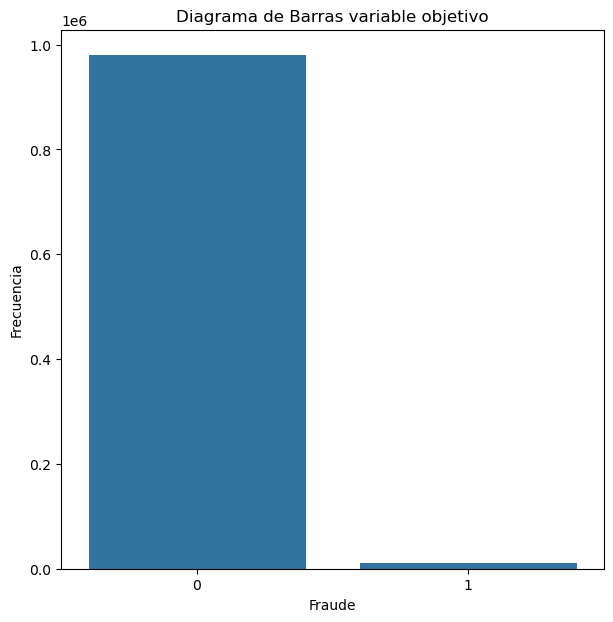

In [15]:
plt.figure(figsize=(7, 7))
sns.countplot(x=df['fraud_bool'])
plt.xlabel("Fraude")
plt.ylabel("Frecuencia")
plt.title("Diagrama de Barras variable objetivo")

print(df['fraud_bool'].value_counts()/len(df) * 100)
plt.show()

Observo que está muy desbalanceado y que hay muy pocos datos etiquetados con el valor 1.

# Clasificación

## Técnicas de balanceo

Hay diferentes técnicas que nos permiten lidiar con el desbalanceo de la variable objetivo. Aquí se describen algunas de ellas:

1. Remuestreo de datos:
    * Sobremuestreo (Oversampling): Aumenta el número de instancias de la clase minoritaria.
    * Submuestreo (Undersampling): Reduce el número de instancias de la clase mayoritaria.
    * Remuestreo combinado: Combina técnicas de sobremuestreo y submuestreo para equilibrar las clases.
2. Generación de muestras sintéticas:
    * SMOTE (Synthetic Minority Over-sampling Technique): Genera nuevas instancias sintéticas de la clase minoritaria mediante interpolación entre instancias similares.
3. Ponderación de clases:
    * Ajusta los pesos de las clases durante el entrenamiento para dar más importancia a la clase minoritaria.

A continuación genera diferentes datasets aplicando las diferentes técnicas e implementa un modelo de clasificación con cada uno de ellos y analiza las diferencias.


In [19]:
#En primer lugar divide los datos en conjunto de entrenamiento y train.
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=1994)

Las técnicas de balanceo se aplicarán sobre los conjuntos de entrenamiento. El conjunto de test debe de ser el inicial, que sea un conjunto que el modelo no haya visto ni haya sido modificado.

### Oversampling: 
Implica duplicar instancias aleatorias de la clase minoritaria hasta que se equilibre con la clase mayoritaria.
El código para realizar esta ténica se proporciona.

In [22]:
oversample = RandomOverSampler(sampling_strategy='minority')
X_over, y_over = oversample.fit_resample(X_train, y_train)

### Undersampling: 
Implica eliminar instancias aleatorias de la clase mayoriataria hasta que se equilibre con la clase mayoritaria.
El código para realizar esta ténica se proporciona.

In [24]:
undersample = RandomUnderSampler(sampling_strategy='majority')
X_under, y_under = undersample.fit_resample(X_train, y_train)

### SMOTE: 
SMOTE genera instancias sintéticas de la clase minoritaria basándose en los datos existentes, lo que reduce el riesgo de sobreajuste.
El código para realizar esta ténica se proporciona.

In [26]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

## Modelado

Para este caso práctico aplicara el algoritmo Random Forest para calcular las predicciones. Aplica este modelo utilizando cada uno de los conjuntos de datos generados anteriormente y obtén las métricas para evaluar el rendimienot del modelo. ¿Qué técnica ha funcionado mejor? 
¿Por qué?

Si no recuerdas como realizar un modelo de clasificación y su evaluación, puedes repasar lo visto en el caso práctico de la Unidad 1.

*Idea*:En el caso que creas necesario obtén las métricas de predicción sobre el conjunto de entrenamiento para analizar si hay overfitting.



### Dataset original: 
Ejecuta el modelo y analiza sus métricas con el dataset original desbalanceado. ¿Qué observas? ¿Qué conclusiones puedes extraer?

In [29]:
# Lo hago con 100 árboles
rf = RandomForestClassifier(n_estimators=100, random_state=42)
# Ajusto el modelo con los datos originales
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [30]:
# Ahora hago las predicciones
y_pred = rf.predict(X_test)

# Evalúo con las métricas
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))

Accuracy: 0.9986571421359517
Precision: 0.9804413239719157
Recall: 0.8959670027497708
F1: 0.9363026819923371


### Oversampling dataset
Entrena el modelo con el dataset sobre el que aplicaste la técnica de oversampling y analiza sus métricas. ¿Qué observas? ¿Qué conclusiones puedes extraer?

In [32]:
# Lo hago con 100 árboles
rf = RandomForestClassifier(n_estimators=100, random_state=42)
# Ajusto el modelo con los datos después del oversampling
rf.fit(X_over, y_over)

RandomForestClassifier(random_state=42)

In [33]:
# Ahora hago las predicciones
y_pred = rf.predict(X_test)

# Evalúo con las métricas
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))

Accuracy: 0.9987530605548123
Precision: 0.9806259314456036
Recall: 0.9046746104491292
F1: 0.9411203814064363


**Observo que ha mejorado el recall y el f1, y en problemas de fraude como este, eso es importante, porque minimizar falsos negativos es lo principal.**

### Undersampling dataset
Entrena el modelo con el dataset sobre el que aplicaste la técnica de undersampling y analiza sus métricas. ¿Qué observas? ¿Qué conclusiones puedes extraer?

In [36]:
# Lo hago con 100 árboles
rf = RandomForestClassifier(n_estimators=100, random_state=42)
# Ajusto el modelo con los datos después del undersampling
rf.fit(X_under, y_under)

RandomForestClassifier(random_state=42)

In [37]:
# Ahora hago las predicciones
y_pred = rf.predict(X_test)

# Evalúo con las métricas
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))

Accuracy: 0.9872579953050458
Precision: 0.46254927726675427
Recall: 0.9679193400549955
F1: 0.6259632483698874


**Observo que han bajado mucho las métricas de `precision` y `f1` y veo que ha mejorado la de `recall`. Esto se debe a que al reducir gran parte de la clase mayoritaria, se ha perdido información y precisión.**

### SMOTE dataset
Entrena el modelo con el dataset sobre el que aplicaste la técnica de SMOTE y analiza sus métricas. ¿Qué observas? ¿Qué conclusiones puedes extraer?

In [40]:
# Lo hago con 100 árboles
rf = RandomForestClassifier(n_estimators=100, random_state=42)
# Ajusto el modelo con los datos después del undersampling
rf.fit(X_resampled, y_resampled)

RandomForestClassifier(random_state=42)

In [41]:
# Ahora hago las predicciones
y_pred = rf.predict(X_test)

# Evalúo con las métricas
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))

Accuracy: 0.997803973041876
Precision: 0.9149643705463183
Recall: 0.8826764436296975
F1: 0.8985304408677397


**Observo lo mismo que con oversampling en cuanto a recall, lo que pasa es que se ha reducido la precisión, y esto es malo porque aumenta el número de falsos positivos. Sobretodo si alguien es detectado de forma errónea haciendo fraude y por ejemplo se le bloquea la cuenta del banco.**

#### Conclusiones

¿Qué conclusiones sacas tras aplicar el modelo utilizando las diferentes técnicas?

**Saco las conclusiones de que para este problema undersampling es un peligro porque al estar tan desbalanceados los datos se pierde demasiada información y que oversampling es la mejor opción porque SMOTE crea instancias sintéticas que hacen que haya más generalización y que baje el recall.**

# Clustering

En esta sección queremos segmentar los tipos de transacciones fraudulentas y no fraudulentas para analizar si hay tipos de transacciones con patrones comunes.
Para ello aplica un algoritmo de clustering. Tal y como aprendimos en la Unidad 2, utilizaremos k-Means.

Elimina la variable objetivo para la segmentación.

Hice funciones por si había que aplicar a más de un dataset.

Según lo dicho en el foro, solo hay que aplicarlo al database original.

Me hago una función para escalar las variables numéricas. Antes estaban sin escalar para favorecer su interpretación.

In [50]:
def scale_dataset(dataset):
    scaler = StandardScaler()
    num_cols_scaled = scaler.fit_transform(dataset)
    # Lo hago un dataframe para que no me de warning
    return pd.DataFrame(num_cols_scaled, columns=dataset.columns, index=dataset.index)

Hago una función para aplicar el kmeans.

In [52]:
def apply_kmeans(num_clusters, dataset):
    kmeans = KMeans(n_clusters=num_clusters, random_state=1993)
    kmeans.fit(dataset)
    # Me guardo en una columna el cluster asignado a cada fila
    return kmeans.labels_

#### Dataset original

In [54]:
df[features]

,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,intended_balcon_amount,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,credit_risk_score,email_is_free,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,session_length_in_minutes,keep_alive_session,payment_type_AC,employment_status_CB,employment_status_CF,employment_status_Other,housing_status_BB,housing_status_BC,housing_status_BE,housing_status_Other,device_os_macintosh,device_os_other,device_os_windows
0,0.3,0.986506,34.0,25.0,40,102.453711,1059,13096.035018,7850.955007,6742.080561,5,5,163.0,1,0,1,9.0,0,1500.0,0,16.224843,1,0,1,0,0,0,1,0,0,0,0,0
1,0.8,0.617426,34.0,89.0,20,-0.849551,1658,9223.283431,5745.251481,5941.664859,3,18,154.0,1,1,1,2.0,0,1500.0,0,3.363854,1,0,0,0,0,0,1,0,0,0,1,0
2,0.8,0.996707,9.0,14.0,40,-1.490386,1095,4471.472149,5471.988958,5992.555113,15,11,89.0,1,0,1,30.0,0,200.0,0,22.730559,0,0,0,0,0,0,1,0,0,0,0,1
3,0.6,0.475100,11.0,14.0,30,-1.863101,3483,14431.993621,6755.344479,5970.336831,11,13,90.0,1,0,1,1.0,0,200.0,0,15.215816,1,0,0,0,0,0,1,0,0,0,0,0
4,0.9,0.842307,34.0,29.0,40,47.152498,2339,7601.511579,5124.046930,5940.734212,1,6,91.0,0,1,1,26.0,0,200.0,0,3.743048,0,0,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
990420,0.8,0.124690,34.0,143.0,30,-0.826239,530,6732.602414,3010.048099,3095.754245,42,8,305.0,1,1,1,31.0,0,1500.0,0,16.967770,0,0,0,0,0,1,0,0,0,0,1,0
990421,0.9,0.824544,34.0,193.0,30,0.008307,408,1574.293294,2716.495767,4286.089050,0,5,235.0,0,1,1,15.0,1,1000.0,0,1.504109,0,1,0,0,0,0,0,0,0,1,0,0
990422,0.8,0.140891,34.0,202.0,10,50.609995,749,1258.864938,3601.322892,3103.891664,2,3,195.0,1,0,1,31.0,0,200.0,0,16.068595,0,0,0,0,0,0,0,1,0,0,1,0
990423,0.9,0.002480,52.0,3.0,30,-1.313387,707,7048.137128,6521.395012,3068.265084,7,8,148.0,0,0,1,1.0,0,200.0,0,1.378683,1,0,0,0,0,0,0,0,1,0,0,0


In [55]:
numerical_columns = list(df[features].select_dtypes(include=['float64', 'int64']))
numerical_columns

['income',
 'name_email_similarity',
 'prev_address_months_count',
 'current_address_months_count',
 'customer_age',
 'intended_balcon_amount',
 'zip_count_4w',
 'velocity_6h',
 'velocity_24h',
 'velocity_4w',
 'bank_branch_count_8w',
 'date_of_birth_distinct_emails_4w',
 'credit_risk_score',
 'bank_months_count',
 'proposed_credit_limit',
 'session_length_in_minutes']

Escalo los datos para hacer el clustering.

In [57]:
df[numerical_columns] = scale_dataset(df[numerical_columns])
df[features]

,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,intended_balcon_amount,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,credit_risk_score,email_is_free,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,session_length_in_minutes,keep_alive_session,payment_type_AC,employment_status_CB,employment_status_CF,employment_status_Other,housing_status_BB,housing_status_BC,housing_status_BE,housing_status_Other,device_os_macintosh,device_os_other,device_os_windows
0,-0.905181,1.703627,-0.216910,-0.700903,0.524451,4.626898,-0.511889,2.468327,2.083326,2.050884,-0.390792,-0.894304,0.524055,1,0,1,-0.594110,0,2.016434,0,1.079762,1,0,1,0,0,0,1,0,0,0,0,0
1,0.817042,0.427129,-0.216910,0.022997,-1.139036,-0.471146,0.083750,1.181473,0.659445,1.180185,-0.395138,1.688213,0.382899,1,1,1,-1.296358,0,2.016434,0,-0.522352,1,0,0,0,0,0,1,0,0,0,1,0
2,0.817042,1.738907,-0.910252,-0.825323,0.524451,-0.502771,-0.476091,-0.397479,0.474664,1.235543,-0.369064,0.297627,-0.636555,1,0,1,1.512635,0,-0.648452,0,1.890190,0,0,0,0,0,0,1,0,0,0,0,1
3,0.128153,-0.065119,-0.854784,-0.825323,-0.307292,-0.521165,1.898511,2.912245,1.342472,1.211374,-0.377755,0.694937,-0.620871,1,0,1,-1.396680,0,-0.648452,0,0.954066,1,0,0,0,0,0,1,0,0,0,0,0
4,1.161486,1.204900,-0.216910,-0.655659,0.524451,1.897768,0.760930,0.642584,0.239385,1.179172,-0.399483,-0.695649,-0.605187,0,1,1,1.111350,0,-0.648452,0,-0.475115,0,0,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
990420,0.817042,-1.277042,-0.216910,0.633787,-0.307292,-0.469995,-1.037921,0.353859,-1.190106,-1.915621,-0.310397,-0.298338,2.751170,1,1,1,1.612956,0,2.016434,0,1.172310,0,0,0,0,0,1,0,0,0,0,1,0
990421,1.161486,1.143466,-0.216910,1.199334,-0.307292,-0.428810,-1.159237,-1.360166,-1.388607,-0.620765,-0.401656,-0.894304,1.653296,0,1,1,0.007817,1,0.991478,0,-0.754023,0,1,0,0,0,0,0,0,0,1,0,0
990422,0.817042,-1.221010,-0.216910,1.301132,-1.970779,2.068397,-0.820150,-1.464978,-0.790285,-1.906769,-0.397310,-1.291614,1.025940,1,0,1,1.612956,0,-0.648452,0,1.060298,0,0,0,0,0,0,0,1,0,0,1,0
990423,1.161486,-1.699717,0.282297,-0.949743,-0.307292,-0.494036,-0.861914,0.458706,1.184275,-1.945524,-0.386446,-0.298338,0.288796,0,0,1,-1.396680,0,-0.648452,0,-0.769648,1,0,0,0,0,0,0,0,1,0,0,0


Aplica el método del codo para obtener el número óptimo de clusters previamente

In [59]:
inertias = []

for k in range(1,10):
    kmeans = KMeans(n_clusters=k, random_state=1993)
    kmeans.fit(df[features])
    inertias.append(kmeans.inertia_)

Lo grafico.

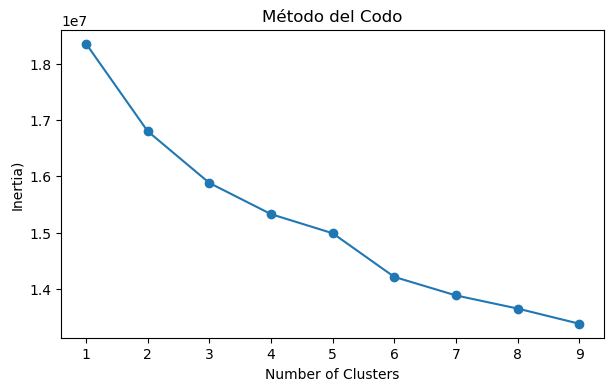

In [61]:
plt.figure(figsize=(7, 4))
plt.plot(range(1, 10), inertias, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia)')
plt.title('Método del Codo')
plt.show()

Me voy a quedar con 5.

Aplica el algoritmo k_means. Para cada conjunto de datos printea el número de registros que pertenen a dicho cluster y estadísticos de cada variable numérica. Para las variables binarias puedes graficar la cantidad de 0s y 1s por cluster.
¿Qué observas? ¿Tienen los clusters un tamaño similar? 

*Idea*: Puedes guardar la media por ejemplo de cada variable por cluster en un dataframe, de forma que tengas todos los valores agrupados y se más fácil de comparar.

In [64]:
df['kmeans'] = apply_kmeans(5, df[features])
# Imprimo el numero de registros por cada cluster
print("Numero de registros pertenecientes a cada cluster")
print(df['kmeans'].value_counts())
# Y su porcentaje
print("Porcentajes del numero de registros pertenecientes a cada cluster")
print(df['kmeans'].value_counts() / len(df) * 100)

Numero de registros pertenecientes a cada cluster
kmeans
4    248874
2    204728
1    193935
3    174126
0    168762
Name: count, dtype: int64
Porcentajes del numero de registros pertenecientes a cada cluster
kmeans
4    25.128001
2    20.670722
1    19.580988
3    17.580937
0    17.039352
Name: count, dtype: float64


**Observo que los clusters tienen un tamaño parecido aunque no similar ya que el porcentaje de cluster 4 tiene un 8% más de registros que el 0. Por lo que creo que siguen balanceados aunque no son similares.**

In [66]:
features = list(features)
features

['income',
 'name_email_similarity',
 'prev_address_months_count',
 'current_address_months_count',
 'customer_age',
 'intended_balcon_amount',
 'zip_count_4w',
 'velocity_6h',
 'velocity_24h',
 'velocity_4w',
 'bank_branch_count_8w',
 'date_of_birth_distinct_emails_4w',
 'credit_risk_score',
 'email_is_free',
 'phone_home_valid',
 'phone_mobile_valid',
 'bank_months_count',
 'has_other_cards',
 'proposed_credit_limit',
 'foreign_request',
 'session_length_in_minutes',
 'keep_alive_session',
 'payment_type_AC',
 'employment_status_CB',
 'employment_status_CF',
 'employment_status_Other',
 'housing_status_BB',
 'housing_status_BC',
 'housing_status_BE',
 'housing_status_Other',
 'device_os_macintosh',
 'device_os_other',
 'device_os_windows']

Aquí los estadísticos de cada variable numérica.

In [68]:
features.append('kmeans')

In [69]:
df[features].groupby('kmeans')[numerical_columns].describe()

income                                                              \
           count      mean       std       min       25%       50%       75%   
kmeans                                                                         
0       168762.0  0.010476  0.969558 -1.594069 -0.905181  0.128153  0.817042   
1       193935.0 -0.974950  0.727247 -1.594069 -1.594069 -1.249625 -0.560736   
2       204728.0  0.109743  0.923013 -1.594069 -0.560736  0.472597  0.817042   
3       174126.0  0.235283  0.940523 -1.594069 -0.560736  0.472597  1.161486   
4       248874.0  0.497732  0.757082 -1.594069  0.128153  0.817042  1.161486   

                 name_email_similarity                                \
             max                 count      mean       std       min   
kmeans                                                                 
0       1.161486              168762.0 -0.107079  1.021273 -1.708229   
1       1.161486              193935.0  0.218863  0.973266 -1.707974   
2       1.161486              204728.0 -0.035936  1.001707 -1.708290   
3       1.161486              174126.0  0.197964  0.978122 -1.708225   
4       1.161486              248874.0 -0.206884  0.960756 -1.708228   

                                               prev_address_months_count  \
             25%       50%       75%       max                     count   
kmeans                                                                     
0      -1.083436 -0.117787  0.822403  1.750286                  168762.0   
1      -0.619512  0.293344  1.118263  1.750290                  193935.0   
2      -0.973516 -0.033325  0.851908  1.750294                  204728.0   
3      -0.661296  0.282013  1.087772  1.750292                  174126.0   
4      -1.045085 -0.353461  0.593748  1.750293                  248874.0   

                                                                           \
            mean       std       min      25%      50%      75%       max   
kmeans                                                                      
0      -0.080973  0.764453 -0.993453 -0.21691 -0.21691 -0.21691  9.295747   
1      -0.126556  0.691837 -0.993453 -0.21691 -0.21691 -0.21691  9.129344   
2       0.137490  1.323722 -0.993453 -0.21691 -0.21691 -0.21691  9.184812   
3      -0.051597  0.845559 -0.993453 -0.21691 -0.21691 -0.21691  9.212546   
4       0.076526  1.108395 -1.021187 -0.21691 -0.21691 -0.21691  9.462149   

       current_address_months_count                                          \
                              count      mean       std       min       25%   
kmeans                                                                        
0                          168762.0  0.426693  1.146562 -0.983676 -0.508617   
1                          193935.0  0.026859  1.029166 -0.983676 -0.746147   
2                          204728.0 -0.334923  0.775425 -0.983676 -0.847945   
3                          174126.0  0.355800  1.095435 -0.983676 -0.553861   
4                          248874.0 -0.283696  0.737081 -0.983676 -0.836634   

                                     customer_age                      \
             50%       75%       max        count      mean       std   
kmeans                                                                  
0       0.136106  1.131468  3.857403     168762.0  1.132239  0.810740   
1      -0.372886  0.452812  3.823470     193935.0 -0.702022  0.653583   
2      -0.576483 -0.203222  3.744294     204728.0 -0.464116  0.701275   
3       0.079551  1.052292  3.699050     174126.0  0.364557  0.930513   
4      -0.542550  0.022997  3.518075     248874.0 -0.093997  0.811379   

                                                          \
             min       25%       50%       75%       max   
kmeans                                                     
0      -1.970779  0.524451  1.356195  1.356195  4.683169   
1      -1.970779 -1.139036 -1.139036 -0.307292  3.019682   
2      -1.970779 -1.139036 -0.307292 -0.307292  

In [70]:
# Agrupo según los clusters
# Después uso apply para aplicar a cada conjunto de datos que hay dentro de cada cluster la función lambda que aplica a su vez un value counts
df[features].groupby('kmeans')[binary_columns].apply(lambda x: x.apply(pd.Series.value_counts))

email_is_free  phone_home_valid  phone_mobile_valid  \
kmeans                                                          
0      0          81316             68468               33644   
       1          87446            100294              135118   
1      0          88728            131086               15313   
       1         105207             62849              178622   
2      0          86104            142510               16540   
       1         118624             62218              188188   
3      0          85379             97968               22075   
       1          88747             76158              152051   
4      0         124519            137060               21726   
       1         124355            111814              227148   

          has_other_cards  foreign_request  keep_alive_session  \
kmeans                                                           
0      0           124811           165059               81801   
       1            43951             3703               86961   
1      0           164619           189738               80163   
       1            29316             4197              113772   
2      0           170141           198411               78076   
       1            34587             6317              126652   
3      0           119626           168850               78136   
       1            54500             5276               95990   
4      0           190044           243353              100088   
       1            58830             5521              148786   

          payment_type_AC  employment_status_CB  employment_status_CF  \
kmeans                                                                  
0      0           133605                141280                158890   
       1            35157                 27482                  9872   
1      0           133617                174906                182783   
       1            60318                 19029                 11152   
2      0           160143                165931                196111   
       1            44585                 38797                  8617   
3      0           133350                151652                170755   
       1            40776                 22474                  3371   
4      0           180732                219447                238160   
       1            68142                 29427                 10714   

          employment_status_Other  housing_status_BB  housing_status_BC  \
kmeans                                                                    
0      0                   134264             104568             117100   
       1                    34498              64194              51662   
1      0                   175541             143522             130853   
       1                    18394              50413              63082   
2      0                   193880             160717             104487   
       1                    10848              44011             100241   
3      0                   164645             141154             126189   
       1                     9481              32972              47937   
4      0                   235521             181706             144662   
       1                    13353              67168             104212   

          housing_status_BE  housing_status_Other  device_os_macintosh  \
kmeans                                                                   
0      0             154492                164064               161289   
       1              14270                  4698                 7473   
1      0             128175                189924               182822   
       1              65760                  4011                11113   
2      0             163783                199897               194129   
       1              40945                  4831                10599   
3      0             155581                169445               16

In [71]:
df_binary_mean = df[features].groupby('kmeans')[binary_columns].mean()
df_binary_mean

,email_is_free,phone_home_valid,phone_mobile_valid,has_other_cards,foreign_request,keep_alive_session,payment_type_AC,employment_status_CB,employment_status_CF,employment_status_Other,housing_status_BB,housing_status_BC,housing_status_BE,housing_status_Other,device_os_macintosh,device_os_other,device_os_windows
kmeans,,,,,,,,,,,,,,,,,
0,0.518162,0.594293,0.800642,0.260432,0.021942,0.515288,0.208323,0.162845,0.058497,0.204418,0.380382,0.306123,0.084557,0.027838,0.044281,0.270351,0.316120
1,0.542486,0.324072,0.921041,0.151164,0.021641,0.586650,0.311022,0.098121,0.057504,0.094846,0.259948,0.325274,0.339083,0.020682,0.057303,0.364756,0.227612
2,0.579422,0.303906,0.919210,0.168941,0.030856,0.618635,0.217777,0.189505,0.042090,0.052987,0.214973,0.489630,0.199997,0.023597,0.051771,0.379674,0.212013
3,0.509671,0.437373,0.873224,0.312992,0.030300,0.551267,0.234175,0.129067,0.019360,0.054449,0.189357,0.275301,0.106503,0.026883,0.056786,0.310063,0.359963
4,0.499671,0.449280,0.912703,0.236385,0.022184,0.597837,0.273801,0.118241,0.043050,0.053654,0.269888,0.418734,0.114729,0.038630,0.057234,0.393010,0.232487


**Observo que hay variables bien balanceadas como email_is_free donde en todos los clusters su media de 0 y 1 es 50% aproximadamente y luego hay variables muy desbalanceadas como foreign_request donde en todos los clusters la media indica que casi todos los datos son 0s. Las variables balanceadas pueden ser más útiles para diferenciar clusters.**

### Sólo fraude

Ahora realiza la clusterización sólo seleccionando las transacciones fraudulentas

In [74]:
df.drop(columns=['kmeans'])
features.remove('kmeans')

In [75]:
# Selecciono las filas donde target sea 1 y me vuelvo a quedar con solo las columnas guardadas en features
df_fraudulent = df[df[target] == 1][features].copy()

Aplica el método del codo para obtener el número óptimo de clusters previamente

In [77]:
inertias = []

for k in range(2,10):
    kmeans = KMeans(n_clusters=k, random_state=1993)
    kmeans.fit(df_fraudulent)
    inertias.append(kmeans.inertia_)

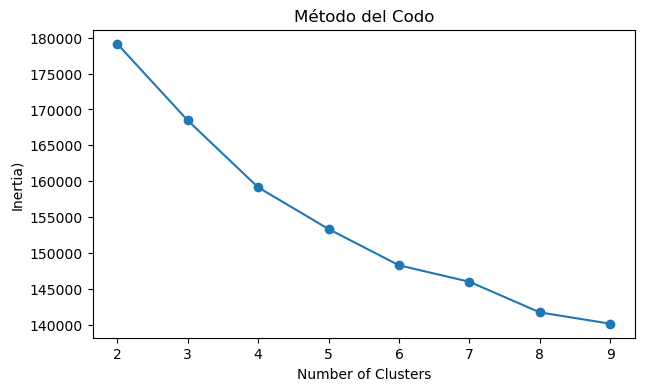

In [78]:
plt.figure(figsize=(7, 4))
plt.plot(range(2, 10), inertias, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia)')
plt.title('Método del Codo')
plt.show()

Pondría el codo en 4 o 5.

Aplica el algoritmo k_means. Para cada conjunto de datos printea el número de registros que pertenen a dicho cluster y estadísticos de cada variable numérica. Para las variables binarias puedes graficar la cantidad de 0s y 1s por cluster.
¿Qué observas? ¿Tienen los clusters un tamaño similar? 

*Idea*: Puedes guardar la media por ejemplo de cada variable por cluster en un dataframe, de forma que tengas todos los valores agrupados y se más fácil de comparar.

In [81]:
df_fraudulent['kmeans'] = apply_kmeans(5, df_fraudulent)

In [82]:
# Imprimo el numero de registros por cada cluster
print("Numero de registros pertenecientes a cada cluster")
print(df_fraudulent['kmeans'].value_counts())
# Y su porcentaje
print("Porcentajes del numero de registros pertenecientes a cada cluster")
print(df_fraudulent['kmeans'].value_counts() / len(df_fraudulent) * 100)

Numero de registros pertenecientes a cada cluster
kmeans
1    3832
3    2526
0    2086
2    1901
4     606
Name: count, dtype: int64
Porcentajes del numero de registros pertenecientes a cada cluster
kmeans
1    34.992238
3    23.066387
0    19.048489
2    17.359145
4     5.533741
Name: count, dtype: float64


**Observo que aquí los clusters tienen tamaños más distintos.**

In [84]:
features.append('kmeans')

Estadísticos de las variables numéricas:

In [86]:
df_fraudulent[features].groupby('kmeans')[numerical_columns].describe()

income                                                              \
         count      mean       std       min       25%       50%       75%   
kmeans                                                                       
0       2086.0  0.133767  1.006341 -1.594069 -0.560736  0.472597  1.161486   
1       3832.0  0.618303  0.798322 -1.594069  0.472597  1.161486  1.161486   
2       1901.0  0.217480  0.991930 -1.594069 -0.560736  0.472597  1.161486   
3       2526.0  0.552368  0.837832 -1.594069  0.128153  0.817042  1.161486   
4        606.0  0.370287  0.917270 -1.594069 -0.216292  0.817042  1.161486   

                 name_email_similarity                                \
             max                 count      mean       std       min   
kmeans                                                                 
0       1.161486                2086.0 -0.248715  1.042424 -1.701183   
1       1.161486                3832.0 -0.192258  1.049364 -1.707186   
2       1.161486                1901.0 -0.488647  0.999662 -1.707839   
3       1.161486                2526.0 -0.548322  0.928876 -1.707121   
4       1.161486                 606.0 -0.402885  1.017603 -1.706759   

                                               prev_address_months_count  \
             25%       50%       75%       max                     count   
kmeans                                                                     
0      -1.236200 -0.418597  0.758075  1.749421                    2086.0   
1      -1.176761 -0.443219  0.863064  1.750096                    3832.0   
2      -1.304050 -0.921975  0.332713  1.750134                    1901.0   
3      -1.272986 -0.901584  0.070140  1.749236                    2526.0   
4      -1.270540 -0.689439  0.394979  1.747421                     606.0   

                                                                              \
            mean       std       min       25%       50%       75%       max   
kmeans                                                                         
0       0.398683  0.845466 -0.937986  0.310031  0.310031  0.310031  8.741073   
1       0.363841  0.572600 -0.910252  0.310031  0.310031  0.310031  8.546937   
2       0.380656  0.652076 -0.882518  0.310031  0.310031  0.310031  8.297334   
3       0.382801  0.707600 -0.910252  0.310031  0.310031  0.310031  8.158665   
4       0.387236  0.757754 -0.910252  0.310031  0.310031  0.310031  8.158665   

       current_address_months_count                                          \
                              count      mean       std       min       25%   
kmeans                                                                        
0                            2086.0 -0.008946  0.819981 -0.983676 -0.519928   
1                            3832.0  0.521053  0.979825 -0.983676 -0.237155   
2                            1901.0  0.631479  1.113581 -0.983676 -0.259777   
3                            2526.0  0.035857  0.745532 -0.983676 -0.474684   
4                             606.0  0.323744  0.990354 -0.983676 -0.384197   

                                     customer_age                      \
             50%       75%       max        count      mean       std   
kmeans                                                                  
0      -0.237155  0.271837  3.450210       2086.0 -0.274198  0.756691   
1       0.384947  1.040981  3.393655       3832.0  0.839394  0.952824   
2       0.351014  1.244578  3.404966       1901.0  1.644527  0.789188   
3      -0.124045  0.373636  3.359722       2526.0  0.122080  0.885330   
4       0.113484  0.746897  3.337100        606.0  0.735818  1.041631   

                                                          \
             min       25%       50%       75%       max   
kmeans                                                     
0      -1.970779 -1.139036 -0.307292  0.524451  3.019682   
1      -1.970779  0.524451  0.524451  1.356195  4.683169   
2      -1.139036  1.356195  1.356195  

**De primeras observo que hay bastantes menos variables numéricas al haber reducido a las que tenían fraude que eran minoría en el conjunto de datos original. Además, todas las estadísticas son bastante diferentes a las del conjunto global. Por ejemplo, la media de `income` al aumentar parece que indica que aquellos que tienen más ingresos de la muestra tienden más a fraude según las etiquetas. También veo por ejemplo que la media de `prev_address_month_count` aumenta, lo que parece indicar que aquellos clientes que han estado más meses en residencias previas tienden más a ser fraudulentos.**

Gráficos variables binarias:

In [89]:
# Agrupo según los clusters
# Después uso apply para aplicar a cada conjunto de datos que hay dentro de cada cluster la función lambda que aplica a su vez un value counts
df_fraudulent[features].groupby('kmeans')[binary_columns].apply(lambda x: x.apply(pd.Series.value_counts))

email_is_free  phone_home_valid  phone_mobile_valid  \
kmeans                                                          
0      0            632              1724                 233   
       1           1454               362                1853   
1      0           1369              2849                 632   
       1           2463               983                3200   
2      0            653              1184                 423   
       1           1248               717                1478   
3      0            875              1962                 257   
       1           1651               564                2269   
4      0            186               465                  86   
       1            420               141                 520   

          has_other_cards  foreign_request  keep_alive_session  \
kmeans                                                           
0      0             1947             1990                1253   
       1              139               96                 833   
1      0             3427             3620                2579   
       1              405              212                1253   
2      0             1745             1811                1342   
       1              156               90                 559   
3      0             2337             2408                1574   
       1              189              118                 952   
4      0              568              570                 458   
       1               38               36                 148   

          payment_type_AC  employment_status_CB  employment_status_CF  \
kmeans                                                                  
0      0             1353                  1816                  2053   
       1              733                   270                    33   
1      0             2319                  3590                  3819   
       1             1513                   242                    13   
2      0             1235                  1710                  1893   
       1              666                   191                     8   
3      0             1516                  2326                  2500   
       1             1010                   200                    26   
4      0              350                   562                   601   
       1              256                    44                     5   

          employment_status_Other  housing_status_BB  housing_status_BC  \
kmeans                                                                    
0      0                     2012               1755               1346   
       1                       74                331                740   
1      0                     3560               3482               3411   
       1                      272                350                421   
2      0                     1367               1492               1531   
       1                      534                409                370   
3      0                     2413               2160               1929   
       1                      113                366                597   
4      0                      515                502                466   
       1                       91                104                140   

          housing_status_BE  housing_status_Other  device_os_macintosh  \
kmeans                                                                   
0      0               1802                  2023                 1926   
       1                284                    63                  160   
1      0               3775                  3794                 3601   
       1                 57                    38                  231   
2      0               1857                  1860                 1793   
       1                 44                    41                  108   
3      0               2358                  2447                 

In [90]:
df_binary_mean = df_fraudulent[features].groupby('kmeans')[binary_columns].mean()
df_binary_mean

,email_is_free,phone_home_valid,phone_mobile_valid,has_other_cards,foreign_request,keep_alive_session,payment_type_AC,employment_status_CB,employment_status_CF,employment_status_Other,housing_status_BB,housing_status_BC,housing_status_BE,housing_status_Other,device_os_macintosh,device_os_other,device_os_windows
kmeans,,,,,,,,,,,,,,,,,
0,0.697028,0.173538,0.888303,0.066635,0.046021,0.399329,0.351390,0.129434,0.015820,0.035475,0.158677,0.354746,0.136146,0.030201,0.076702,0.261266,0.472675
1,0.642745,0.256524,0.835073,0.105689,0.055324,0.326983,0.394833,0.063152,0.003392,0.070981,0.091336,0.109864,0.014875,0.009916,0.060282,0.128914,0.697286
2,0.656497,0.377170,0.777486,0.082062,0.047344,0.294056,0.350342,0.100473,0.004208,0.280905,0.215150,0.194634,0.023146,0.021568,0.056812,0.179905,0.593898
3,0.653603,0.223278,0.898258,0.074822,0.046714,0.376880,0.399842,0.079177,0.010293,0.044735,0.144893,0.236342,0.066508,0.031275,0.077593,0.228820,0.516627
4,0.693069,0.232673,0.858086,0.062706,0.059406,0.244224,0.422442,0.072607,0.008251,0.150165,0.171617,0.231023,0.041254,0.021452,0.085809,0.112211,0.627063


**Observo que hay variables como phone_home_valid en las que las medias han bajado para los diferentes clusters, esto puede significar por ejemplo en este caso, que las transacciones fraudulentas suelen tener teléfonos de casa no validados.**

#### k-Means sobre PCA dataset

Dado que vimos que k-Means es un algoritmo basado en distancias, dijimos que era mejor normalizar los datos. Pero también es muy beneficioso utilizar un dataset en el que hemos reducido su dimensionalidad. 
Es una práctica común aplicar PCA antes de un algoritmo de agrupamiento (como k-means) ya que  puede mejorar los resultados de la agrupación en debido a que reducce de ruido.

Utiliza el dataset del Caso Práctico Final de la asignatura de Análisis Exploratorio de Datos en el que aplicabas un PCA sobre tres componentes principales y sobre este dataset aplica k-Means.

Obtén mediante el método del codo el número de clusters idóneo. Realiza un k-means y analiza sus resultados.

Después de realizar el EDA en la otra asignatura, decidí quedarme con 17 componentes principales porque si no perdía demasiada varianza acumulada.

In [95]:
df_pca = pd.read_csv('../Data_Science/datasets/base-pca.csv')

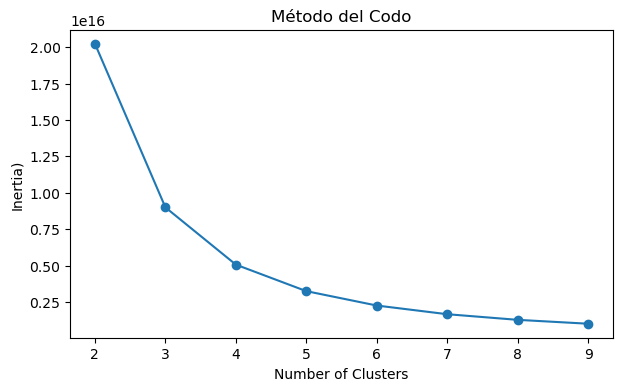

In [96]:
inertias = []

for k in range(2,10):
    kmeans = KMeans(n_clusters=k, random_state=1993)
    kmeans.fit(df_pca)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(7, 4))
plt.plot(range(2, 10), inertias, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia)')
plt.title('Método del Codo')
plt.show()

Creo que el número de clusters idóneo es 3.

In [98]:
kmeans = KMeans(n_clusters=3, random_state=1993)
kmeans.fit(df_pca)
centroids = kmeans.cluster_centers_
df_pca['labels'] = kmeans.predict(df_pca)

In [99]:
df_pca['labels'].value_counts()

labels
1    331328
2    330141
0    328956
Name: count, dtype: int64

Se proporciona el código para realizar una visualización en 3D.

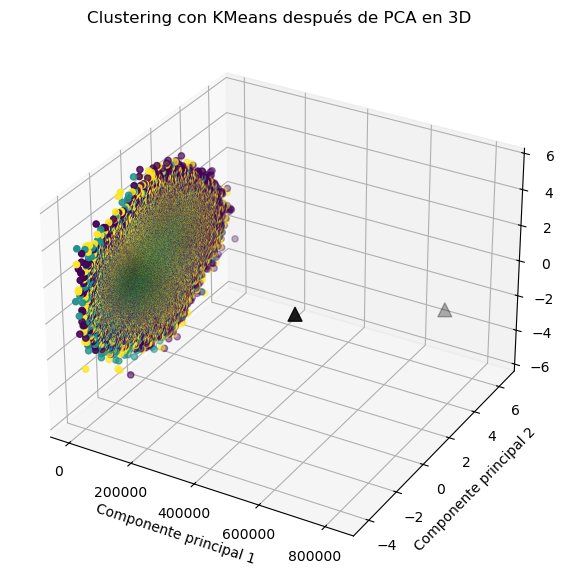

In [101]:
# Visualizar los clusters en 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df_pca['PC1'], df_pca['PC2'], df_pca['PC3'], c=df_pca['labels'], cmap='viridis')
ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], marker='^', s=100, color='black')
ax.set_xlabel('Componente principal 1')
ax.set_ylabel('Componente principal 2')
ax.set_zlabel('Componente principal 3')
ax.set_title('Clustering con KMeans después de PCA en 3D')

plt.show()

**Se me muestran muy mal los datos en mi gráfico 3D, puede ser porque solo estoy usando 3 PC y eso solo representaba el 40% de la varianza de mis datos. Esque veo que hay dos centroides que parecen aislados sin ningún punto alrededor que a lo mejor usando más dimensiones se ve que sí que tienen puntos alrededor.**

Voy a hacer el mismo proceso pero cambiando el PCA a otro numero de componentes porque se me dijo en el foro que jugara con el numero de componentes a pesar de la varianza.

Esta es la gráfica de la varianza representada por cada PC y la varianza acumulada que me salió al realizar la práctica de la otra asignatura:

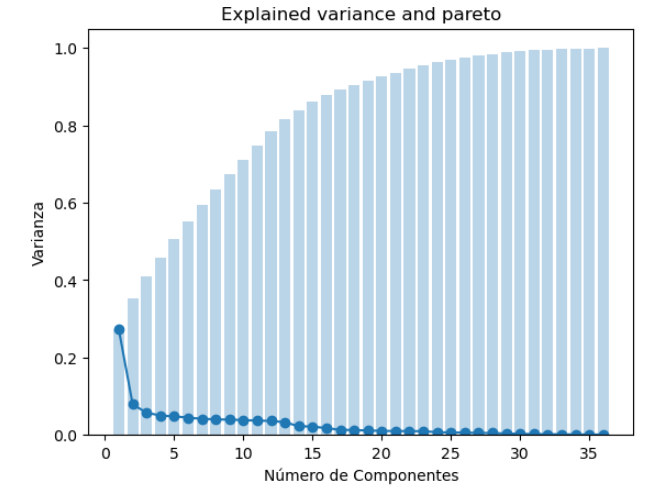

#### kmeans sobre PCA con 3 componentes principales

In [107]:
pca_3 = PCA(n_components=3)
pca_3.fit(df[features])
features_reduced = pca_3.transform(df[features])
print(features_reduced.shape)

(990425, 3)


In [108]:
df_pca_3 = pd.DataFrame(features_reduced, columns=[f'PC{i+1}' for i in range(3)])

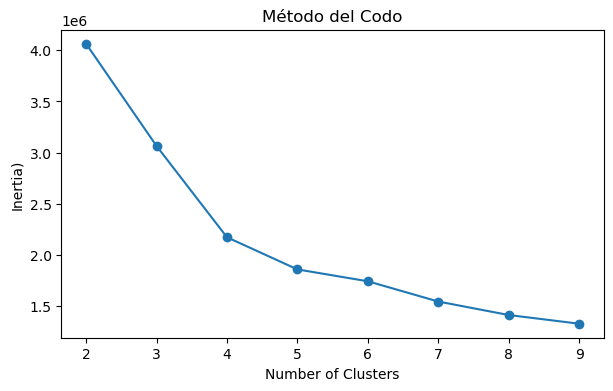

In [109]:
inertias = []

for k in range(2,10):
    kmeans = KMeans(n_clusters=k, random_state=1993)
    kmeans.fit(df_pca_3)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(7, 4))
plt.plot(range(2, 10), inertias, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia)')
plt.title('Método del Codo')
plt.show()

Me quedaría con 4 según el método del codo.

In [111]:
kmeans = KMeans(n_clusters=4, random_state=1993)
kmeans.fit(df_pca_3)
centroids = kmeans.cluster_centers_
df_pca_3['labels'] = kmeans.predict(df_pca_3)

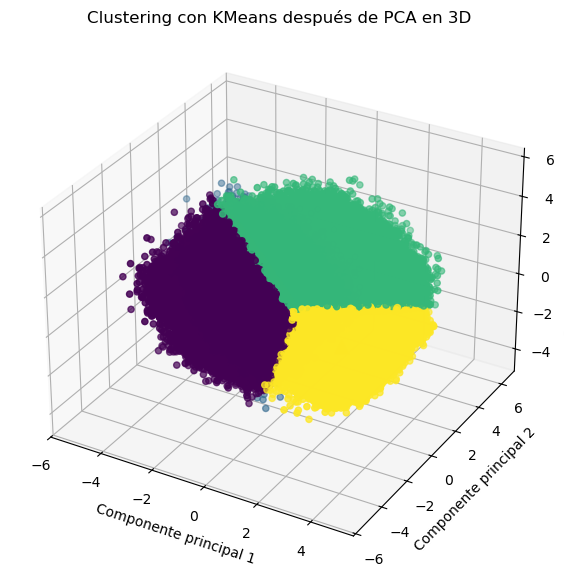

In [112]:
# Visualizar los clusters en 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df_pca_3['PC1'], df_pca_3['PC2'], df_pca_3['PC3'], c=df_pca_3['labels'], cmap='viridis')
ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], marker='^', s=100, color='black')
ax.set_xlabel('Componente principal 1')
ax.set_ylabel('Componente principal 2')
ax.set_zlabel('Componente principal 3')
ax.set_title('Clustering con KMeans después de PCA en 3D')

plt.show()

**Al menos aquí se ve una clara separación entre 3 clusters, esto ya es más que antes donde solo se veía un cumulo de puntos juntos y 2 centroides sin datos cercanos.**